## Challenge
Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in. DO NOT USE either the MNIST digit recognition database or the iris data set. They’ve been worked on in very public ways very very many times and the code is easily available. (However, that code could be a useful resource to refer to)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Load Data
from tensorflow.examples.tutorials.mnist import input_data
# https://github.com/zalandoresearch/fashion-mnist#get-the-data
fashion_data = input_data.read_data_sets('data/fashion')



X = fashion_data.train.next_batch(60000)[:1]
Y = fashion_data.train.next_batch(60000)[1:]

X = np.asarray(X, 'float32')
Y = np.asarray(Y, 'float32').T
X = np.squeeze(X)

X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


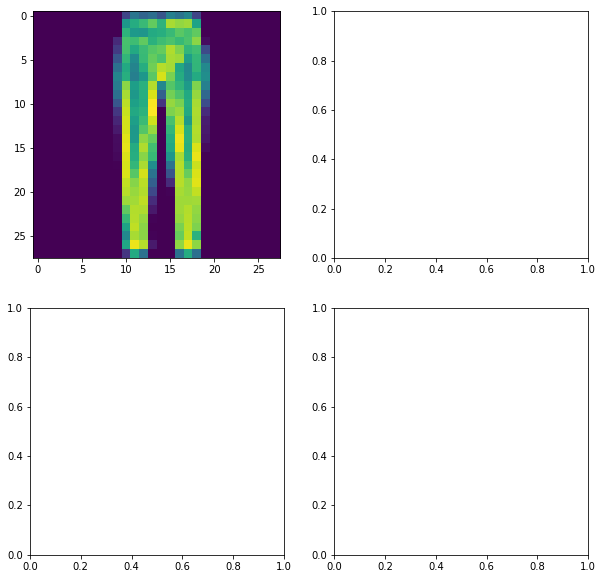

In [8]:
f, axes = plt.subplots(2, 2)
axes[0, 0].imshow(X_train[:1].reshape((28, 28)))
plt.gcf().set_size_inches(10, 10)  

In [9]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.3
rbm.n_iter = 25
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


[BernoulliRBM] Iteration 1, pseudo-likelihood = -230.98, time = 10.88s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -230.34, time = 12.70s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -224.68, time = 11.96s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -221.78, time = 11.89s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -223.03, time = 11.79s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -222.61, time = 11.84s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -227.20, time = 11.86s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -219.11, time = 11.86s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -221.02, time = 11.85s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -218.69, time = 11.86s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -222.19, time = 11.83s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -222.83, time = 11.77s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -223.17, time = 11.80s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -227.26, time = 11.73s
[

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.12      0.10      0.11      1230
         1.0       0.10      0.04      0.06      1199
         2.0       0.10      0.09      0.09      1193
         3.0       0.11      0.17      0.13      1218
         4.0       0.12      0.08      0.09      1187
         5.0       0.10      0.13      0.11      1202
         6.0       0.09      0.12      0.10      1133
         7.0       0.10      0.10      0.10      1224
         8.0       0.10      0.11      0.11      1207
         9.0       0.10      0.08      0.09      1207

   micro avg       0.10      0.10      0.10     12000
   macro avg       0.10      0.10      0.10     12000
weighted avg       0.10      0.10      0.10     12000


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

         0.0       0.10      0.09      0.09      1230
         1.0       0.09      0.09      0.09  

In [10]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
    n = images.shape[0]
    nc = int(np.ceil(n / 4))
    f, axes = pyplot.subplots(nc, 4)
    for i in range(nc * 4):
        y = i // 4
        x = i % 4
        axes[x, y].axis('off')

        label = LABEL_NAMES[np.argmax(predictions[i])]
        confidence = np.max(predictions[i])
        if i > n:
            continue
        axes[x, y].imshow(images[i].reshape((28, 28)))
        axes[x, y].text(0.5, 0.5, label + ' %.3f\n' % confidence, fontsize=10)

    pyplot.gcf().set_size_inches(10, 10)  



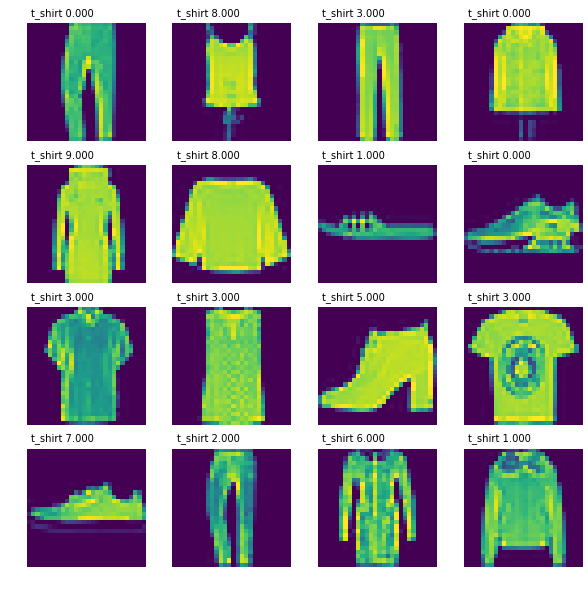

In [11]:
plot_predictions(np.squeeze(X[:16]), 
                 rbm_features_classifier.predict(X_test[:16]))